## Introduction
This notebook is demonstrates detection of COVID-19 affected lungs, and also detection of the region of lungs affected by COVID-19. The notebook also demonstrates my way of handeling and utilizing an imbalanced dataset.                                      

## Import libraries

In [ ]:
import os
import sys
import random
import subprocess
import cv2

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from collections import OrderedDict

import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from scipy.ndimage import binary_dilation
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
random_seed= 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic=True
batch_size = 64
validation_split = .34
shuffle_dataset = True

## Download Dataset

In [ ]:
def run_cmd(cmd, stderr=subprocess.STDOUT):
  out = None
  try:
    out = subprocess.check_output(
      [cmd], 
      shell=True,
      stderr=subprocess.STDOUT, 
      universal_newlines=True,
    )
  except subprocess.CalledProcessError as e:
    print(f'ERROR {e.returncode}: {cmd}\n\t{e.output}', flush=True, file=sys.stderr)
    raise e
  return out

In [ ]:
def clone_data(data_root):
  clone_uri = 'https://github.com/ieee8023/covid-chestxray-dataset.git'
  if os.path.exists(data_root):
      assert os.path.isdir(data_root), \
        f'{data_root} should be cloned from {clone_uri}'
  else:
      print(
        'Cloning the covid chestxray dataset. It may take a while\n...\n', 
        flush=True
        )
      run_cmd(f'git clone {clone_uri} {data_root}')

In [ ]:
data_root = "./data"
mgpath=f'{data_root}/images',
csvpath=f'{data_root}/metadata.csv',

In [ ]:
csvpath

('./data/metadata.csv',)

In [ ]:
clone_data(data_root)

Cloning the covid chestxray dataset. It may take a while
...



In [ ]:
meta = pd.read_csv('data/metadata.csv')

## View
we, are going to train our model against the only "PA" ie. POSTANTERIOR view of the lungs X-ray images.

In [ ]:
meta['view'].value_counts(dropna=False)

PA               205
Axial             41
AP                39
AP Supine         38
L                 27
Coronal            3
AP semi erect      1
Name: view, dtype: int64

In [ ]:
for x in meta['filename']:
    if x.split('.')[-1]=='gz':
        meta.drop(meta.index[meta['filename']==x], 
              inplace=True)

In [ ]:
meta = meta[(meta['finding']!='Chlamydophila')&(meta['finding']!='Legionella')&(meta['finding']!='Klebsiella')
            &(meta['finding']!='No Finding')]
meta = meta[meta['view']=='PA']

In [ ]:
meta['finding'].value_counts(dropna=False)

COVID-19          142
SARS               16
Streptococcus      13
Pneumocystis       13
COVID-19, ARDS     11
ARDS                4
Name: finding, dtype: int64

## Balancing the un-balanced
As you could clearly see that COVID affected x-ray images are ten times more in number than other classes. So in the next cell, we are going to bring down the number of images under COVID.<br>
The excess images of COVID that has been removed from the dataset would be used to detect the region of the lungs that has been affected by COVID-19 through heatmap visualization

In [ ]:
X_train_val, X_test = train_test_split( meta[meta['finding']=='COVID-19'], test_size=0.85, random_state=random_seed)
meta.drop(X_test.index, inplace=True)
meta.reset_index(drop=True, inplace=True)

"X_test" would be used later for testing detection of affected section of lungs through heat-map

In [ ]:
meta['finding'].value_counts(dropna=False)

COVID-19          21
SARS              16
Streptococcus     13
Pneumocystis      13
COVID-19, ARDS    11
ARDS               4
Name: finding, dtype: int64

In [ ]:
dataset_size = len(meta)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

#Shuffling the data to get unbiased results
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
print(len(train_indices),len(val_indices))

52 26


In [ ]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [ ]:
Labels = np.array(meta['finding']).reshape(len(meta['finding']),1)
encode = OneHotEncoder()
encode.fit(Labels)
labels_enc = encode.transform(Labels).toarray()

In [ ]:
transform=transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.RandomCrop(224),                              
                              transforms.ToTensor(),                                                  
                              transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                        ])

In [ ]:
class_names = [
    'COVID-19', 
    'SARS ',
    'Pneumocystis',       
    'Streptococcus',      
    'COVID-19, ARDS',     
    'ARDS',               
]

In [ ]:
class ChestXrayDataSet(Dataset):
    def __init__(self,csvpath,mgpath,labels_enc,transform=None):
      self.meta_data = pd.read_csv(csvpath)
      self.root_dir = mgpath
      self.labels = self.meta_data['finding']
      self.transform = transform
      for x in self.meta_data['filename']:
        if x.split('.')[-1]=='gz':
          self.meta_data.drop(self.meta_data.index[self.meta_data['filename']==x],
                              inplace=True)
    
      self.meta_data = self.meta_data[(self.meta_data['finding']!='Chlamydophila')
                                     &(self.meta_data['finding']!='Legionella')
                                     &(self.meta_data['finding']!='Klebsiella')
                                     &(self.meta_data['finding']!='No Finding')]
      self.meta_data = self.meta_data[self.meta_data['view']=='PA']
      self.meta_data.drop(X_test.index, inplace=True)
      self.meta_data.reset_index(drop=True, inplace=True)
    
    def __len__(self):
      return len(self.meta_data)

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()
      img_name = os.path.join(self.root_dir,
                                self.meta_data.loc[idx,'filename'])
      image = Image.open(img_name).convert('RGB')
      image = np.array(image.resize((256,256)))
      image = image[:,:,0]
      image = np.uint8(((np.array(image)/255).reshape(256,256,1))*255*255)
      image = np.tile(image,3) 
      label = labels_enc[idx]
      if self.transform is not None:
        image = self.transform(image)
      return image, label, idx

In [ ]:
dataset = ChestXrayDataSet(csvpath[0],mgpath[0],labels_enc,transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [ ]:
def img_display(img):
    img = img*0.229+0.485   # unnormalize (inp = inp*std + mean)
    npimg = img.numpy()[0]
  
    return npimg

## Visualizing the dataset

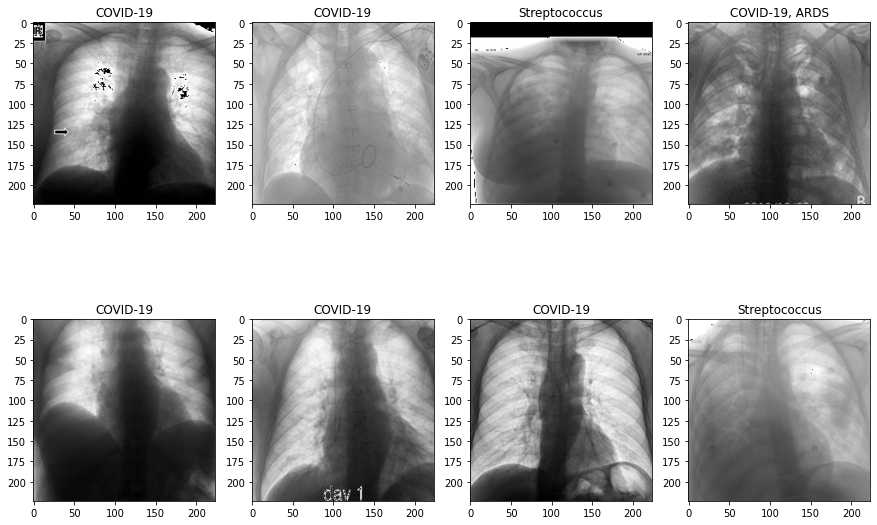

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels, id_ = dataiter.next()
# Viewing data examples used for training
fig, axis = plt.subplots(2, 4, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label, _ = images[i], labels[i], id_[i]
        ax.imshow(img_display(image),cmap='gray') # add image
        ax.set(title = f"{meta['finding'][_.item()]}") # add label
fig.savefig("detection.png")


## Building the model
I have used DenseNet121, for training the model.

In [ ]:
# construct model
class DenseNet121(nn.Module):
  def __init__(self, out_size):
    super(DenseNet121, self).__init__()
    self.densenet121 = torchvision.models.densenet121(pretrained=True)
    num_ftrs = self.densenet121.classifier.in_features
    self.densenet121.classifier = nn.Sequential(
          nn.Linear(num_ftrs, out_size),
          nn.Sigmoid()
      ).cuda()
  def forward(self, x):
    x = self.densenet121(x)
    return x

In [ ]:
cudnn.benchmark = True
N_CLASSES = 6

In [ ]:
def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
      AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

In [ ]:
# initialize and load the model
model = DenseNet121(N_CLASSES)
model = model.cuda(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


NameError: ignored

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.0007,weight_decay=0.0000001)
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.cuda(device)

## Training the model

In [ ]:
# save_best = 0.0
# for epoch in range(245):#245
#   print("Epoch:",epoch)
#   running_loss = 0.0
#   for batch_idx, (data_, target_,_) in enumerate(train_loader):
#     target_ = target_.type(torch.float)
#     data_, target_ = data_.cuda(device), target_.cuda(device)
#     optimizer.zero_grad()
#     outputs = model(data_)
#     loss = criterion(outputs, target_)
#     loss.backward()
#     optimizer.step()
#     running_loss += loss.item()

#   # ======== validation ======== 
# 	# switch to evaluate mode
#   # initialize the ground truth and output tensor
#   with torch.no_grad():
#     model.eval()
#     gt = torch.FloatTensor()
#     gt = gt.cuda()
#     pred = torch.FloatTensor()
#     pred = pred.cuda()
#     for i, (data_t, target_t,_t) in enumerate(validation_loader):
#       target_t = target_t.type(torch.float)
#       data_t, target_t = data_t.cuda(device), target_t.cuda(device)
#       gt = torch.cat((gt, target_t), 0)
#       input_var = Variable(data_t.view(-1, 3, 224, 224).cuda())
#       output = model(input_var)
#       pred = torch.cat((pred, output.data), 0)
#     AUROCs = compute_AUCs(gt, pred)
#     AUROC_avg = np.array(AUROCs).mean()
#     print('The average AUROC is {AUROC_avg:.3f}'.format(AUROC_avg=AUROC_avg))
#     if AUROC_avg>save_best:
#       save_best=AUROC_avg
#       torch.save(model.state_dict(), 'Covid_detection.pt')
#       print('Detected network improvement, saving current model')
#     for i in range(N_CLASSES):
# 		    print('The AUROC of {} is {}'.format(class_names[i], AUROCs[i]))
#   model.train()
# 	# print statistics
#   print('[%d] loss: %.3f' % (epoch + 1, running_loss / 715 ))
#   print("======================================================================\n")
# print('Finished Training')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.load_state_dict(torch.load('drive/My Drive/major_project/Covid_detection.pt'))

<All keys matched successfully>

## GradCAM( Implementation + Visualization)

In [ ]:
class ChestXrayDataSet_plot(Dataset):
	def __init__(self, input_X, transform=None):
		self.data = input_X#np.uint8(test_X*255)
		self.transform = transform
		self.root_dir = mgpath[0]
		self.transform = transform

	def __getitem__(self, index):
	 if torch.is_tensor(index):
		 index = index.tolist()
	 img_name = os.path.join(self.root_dir,self.data.loc[index,'filename'])
	 image = Image.open(img_name).convert('RGB')
	 image = np.array(image.resize((256,256)))
	 #image = image[:,:,0]
	 image = np.uint8(image*255)
	 #image = np.tile(image,3)
	 image = self.transform(image)
	 return image

	def __len__(self):
		return len(self.data)

X_test, which was extracted before would be used as a dataset for the heat-map visualization through gradcam.

In [ ]:
X_test.reset_index(drop=True, inplace=True)
test_dataset = ChestXrayDataSet_plot(input_X = X_test,transform=transforms.Compose([
                                        transforms.ToPILImage(),                                                                
                                        transforms.ToTensor(),               
                                        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                        ]))

In [ ]:
print("generate heatmap ..........")
# ======= Grad CAM Function =========
class PropagationBase(object):
  def __init__(self, model, cuda=True):
    self.model = model
    self.model.eval()
    if cuda:
        self.model.cuda()
    self.cuda = cuda
    self.all_fmaps = OrderedDict()
    self.all_grads = OrderedDict()
    self._set_hook_func()
    self.image = None

  def _set_hook_func(self):
    raise NotImplementedError

  def _encode_one_hot(self, idx):
    one_hot = torch.FloatTensor(1, self.preds.size()[-1]).zero_()
    one_hot[0][idx] = 1.0
    return one_hot.cuda() if self.cuda else one_hot

  def forward(self, image):
    self.image = image
    self.preds = self.model.forward(self.image)
    #self.probs = F.softmax(self.preds, dim=1)[0]
    #self.prob, self.idx = self.preds[0].data.sort(0, True)

    return self.preds.cpu().data.numpy()

  def backward(self, idx):
    self.model.zero_grad()
    one_hot = self._encode_one_hot(idx)
    self.preds.backward(gradient=one_hot, retain_graph=True)

generate heatmap ..........


In [ ]:
class GradCAM(PropagationBase):
  def _set_hook_func(self):
    def func_f(module, input, output):
      self.all_fmaps[id(module)] = output.data.cpu()
    
    def func_b(module, grad_in, grad_out):
      self.all_grads[id(module)] = grad_out[0].cpu()

    for module in self.model.named_modules():
      module[1].register_forward_hook(func_f)
      module[1].register_backward_hook(func_b)

  def _find(self, outputs, target_layer):
    for key, value in outputs.items():
      for module in self.model.named_modules():
        if id(module[1]) == key:
          if module[0] == target_layer:
            return value
    raise ValueError('Invalid layer name: {}'.format(target_layer))

  def _normalize(self, grads):
    l2_norm = torch.sqrt(torch.mean(torch.pow(grads, 2))) + 1e-5
    return grads / l2_norm.item() 
  
  def _compute_grad_weights(self, grads):
    grads = self._normalize(grads)
    self.map_size = grads.size()[2:]
    return nn.AvgPool2d(self.map_size)(grads)

  def generate(self, target_layer):
    fmaps = self._find(self.all_fmaps, target_layer)
    grads = self._find(self.all_grads, target_layer)
    weights = self._compute_grad_weights(grads)
    gcam = torch.FloatTensor(self.map_size).zero_()
    for fmap, weight in zip(fmaps[0], weights[0]):
      gcam += fmap * weight.data
    
    gcam = F.relu(Variable(gcam))
    gcam = gcam.data.cpu().numpy()
    gcam -= gcam.min()
    gcam /= gcam.max()
    gcam = cv2.resize(gcam, (self.image.size(3), self.image.size(2)))    
    return gcam
    
  def FinalImage(self, gcam, raw_image):
    raw_image = raw_image*0.229+0.485
    gcam = cv2.applyColorMap(np.uint8(gcam * 255.0), cv2.COLORMAP_JET)
    gcam = np.float32(gcam) / (600)
    gcam = gcam.astype(np.float) + raw_image.numpy()[0].astype(np.float).reshape(256,256,1)
    gcam = gcam / gcam.max() 
  
    return np.uint8(gcam * 255.0)

In [ ]:
# ======== Create heatmap ===========

heatmap_output = []
image_id = []
output_class = []

thresholds = 0.1
dataiter = iter(validation_loader)
images = dataiter.next()
gcam = GradCAM(model=model, cuda=True)
for index in range(len(test_dataset)):
  input_img = Variable((test_dataset[index]).unsqueeze(0).cuda(), requires_grad=True)
  probs = gcam.forward(input_img)
  activate_classes = np.where((probs > thresholds)[0]==True)[0] # get the activated class
  for activate_class in activate_classes:
    gcam.backward(idx=activate_class)
    output = gcam.generate(target_layer="densenet121.features.denseblock4.denselayer16.conv2")
    #### this output is heatmap ####
    if np.sum(np.isnan(output)) > 0:
      print("fxxx nan")
    img = gcam.FinalImage(output, test_dataset[index])
    heatmap_output.append(img)
    image_id.append(index)
    output_class.append(activate_class)
  print("test ",str(index)," finished")

test  0  finished
test  1  finished
test  2  finished
test  3  finished
test  4  finished
test  5  finished
test  6  finished
test  7  finished
test  8  finished
test  9  finished
test  10  finished
test  11  finished
test  12  finished
test  13  finished
test  14  finished
test  15  finished
test  16  finished
test  17  finished
test  18  finished
test  19  finished
test  20  finished
test  21  finished
test  22  finished
test  23  finished
test  24  finished
test  25  finished
test  26  finished
test  27  finished
test  28  finished
test  29  finished
test  30  finished
test  31  finished
test  32  finished
test  33  finished
test  34  finished
test  35  finished
test  36  finished
test  37  finished
test  38  finished
test  39  finished
test  40  finished
test  41  finished
test  42  finished
test  43  finished
test  44  finished
test  45  finished
test  46  finished
test  47  finished
test  48  finished
test  49  finished
test  50  finished
test  51  finished
test  52  finished
tes

## Heatmap Visualization
All the images in the plot shown below are covid-19 lungs x-ray images, over which we have done heatmap visualization based on predictions done by the model.

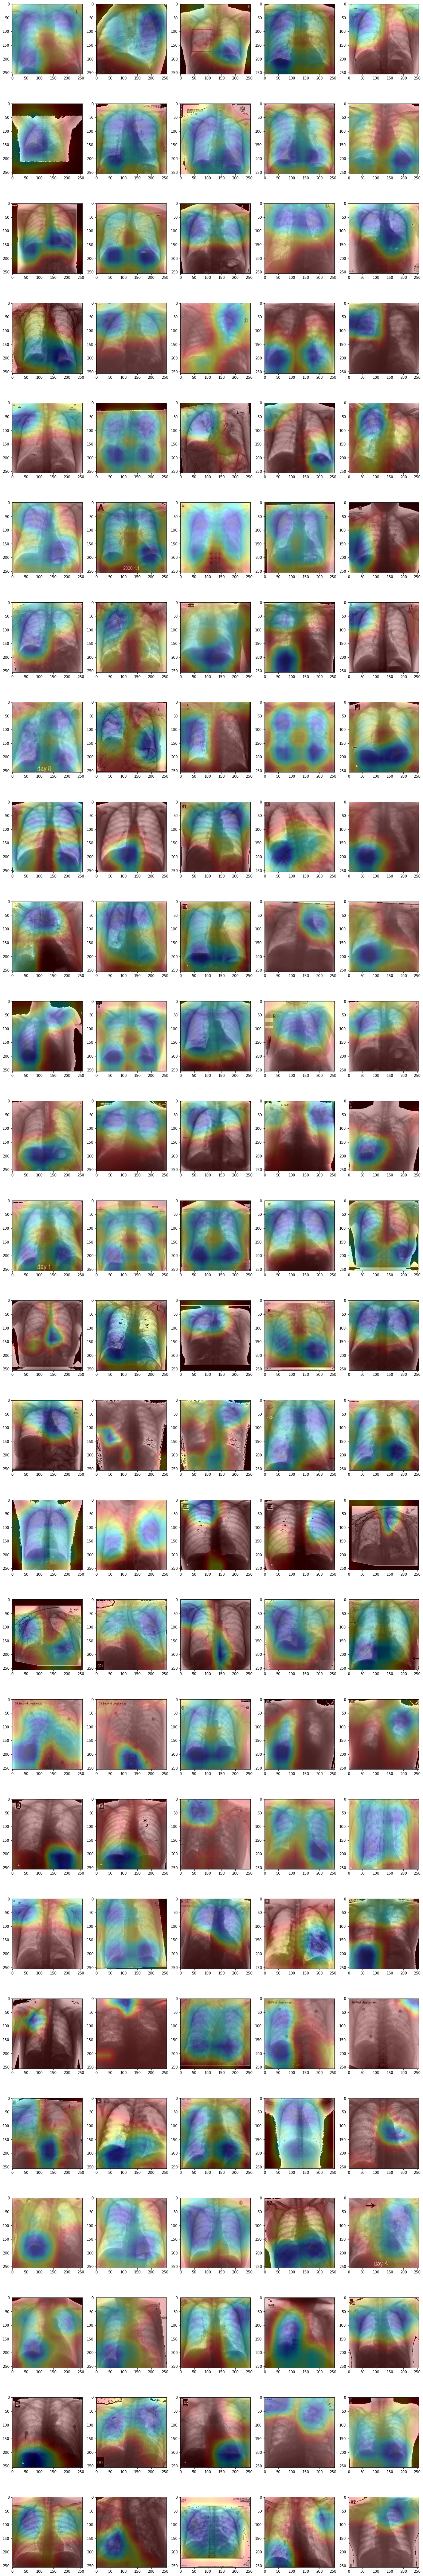

In [ ]:
fig, axis = plt.subplots(26,5, figsize=(20, 130))
# for image in heatmap_output:
#   plt.imshow(image,interpolation='nearest')
#   plt.show()
for i,ax in enumerate(axis.flat):
  ax.imshow(heatmap_output[i]) # add image
#   i=i+1
fig.savefig("heatmap.png")